In [ ]:
import os
import mne
import pandas as pd

# Directorio donde están los archivos .set y .csv
set_dir = r"C:\Users\Usuario\Documents\Datos EEG\PWI_DATOS_EEG_PROCESADOS_BUENOS\Set_Epoch_por_Sujeto_4000ms"

set_dir_marcas = r"C:\Users\Usuario\Documents\FelipeCarriel\EEG_ERP_Analysis\PWI\marcas"

# Diccionario para almacenar las épocas por condición
Epocas = {"con": {}, "rel": {}, "unrel": {}}

# Diccionario para almacenar marcas y eventos por condición
Marcas_Eventos = {"con": {}, "rel": {}, "unrel": {}}

# Condiciones y sus correspondientes sufijos de archivo
condiciones = {
    "con": "PWI_CON",
    "rel": "PWI_INC_REL",
    "unrel": "PWI_INC_UNREL"
}

# Sujetos a excluir
sujetos_excluir = {11, 30}

# Recorre desde S1 hasta S40 para cada condición
for i in range(1, 41):
    sujeto_key = f"Sujeto_{i}"
    
    for condicion, sufijo in condiciones.items():
        if i in sujetos_excluir:
            Epocas[condicion][sujeto_key] = None
            Marcas_Eventos[condicion][sujeto_key] = None
            print(f"{sujeto_key} excluido de la carga en '{condicion}', asignado como None.")
            continue

        # Construir nombre de archivo .set
        file_name_set = f"S{i}_{sufijo}.set"
        file_path_set = os.path.join(set_dir, file_name_set)

        # Construir nombre de archivo .csv
        file_name_csv = f"S{i}_{sufijo}_Marcas_Eventos.csv"
        file_path_csv = os.path.join(set_dir_marcas, file_name_csv)

        # Manejo de archivos .set
        try:
            epochs = mne.io.read_epochs_eeglab(file_path_set)
            Epocas[condicion][sujeto_key] = epochs
            print(f"{file_name_set} cargado exitosamente en '{condicion}'.")
        except FileNotFoundError:
            Epocas[condicion][sujeto_key] = None
            print(f"{file_name_set} no encontrado en '{condicion}'.")
        except Exception as e:
            Epocas[condicion][sujeto_key] = None
            print(f"Error al cargar {file_name_set} en '{condicion}': {e}")

        # Manejo de archivos .csv
        try:
            marcas_eventos_df = pd.read_csv(file_path_csv)
            Marcas_Eventos[condicion][sujeto_key] = marcas_eventos_df
            print(f"{file_name_csv} cargado exitosamente en '{condicion}'.")
        except FileNotFoundError:
            Marcas_Eventos[condicion][sujeto_key] = None
            print(f"{file_name_csv} no encontrado en '{condicion}'.")
        except Exception as e:
            Marcas_Eventos[condicion][sujeto_key] = None
            print(f"Error al cargar {file_name_csv} en '{condicion}': {e}")


In [63]:
Marcas_Eventos

{'con': {'Sujeto_1':      Type  Latency
  0    S 11      206
  1    S 31      887
  2    S 11     4507
  3    S 11     8808
  4    S 11    13109
  ..    ...      ...
  174  S 31   379511
  175  S 11   382995
  176  S 31   383802
  177  S 11   387296
  178  S 31   388044
  
  [179 rows x 2 columns],
  'Sujeto_2':      Type  Latency
  0    S 11      206
  1    S 31      861
  2    S 11     4507
  3    S 31     5176
  4    S 11     8808
  ..    ...      ...
  147  S 31   319111
  148  S 11   322781
  149  S 31   323519
  150  S 11   327082
  151  S 31   328013
  
  [152 rows x 2 columns],
  'Sujeto_3':      Type  Latency
  0    S 11      206
  1    S 31     1029
  2    S 11     4507
  3    S 31     5398
  4    S 11     8808
  ..    ...      ...
  181  S 31   392476
  182  S 11   395898
  183  S 31   396392
  184  S 11   400199
  185  S 31   401020
  
  [186 rows x 2 columns],
  'Sujeto_4':      Type  Latency
  0    S 11      206
  1    S 31     1077
  2    S 11     4507
  3    S 31     55

In [64]:
Marcas_Eventos['unrel']['Sujeto_37']

,Type,Latency
0,S 23,206
1,S 43,1217
2,S 1,3807
3,S 23,4507
4,S 43,5281
...,...,...
243,S 43,353668
244,S 1,356489
245,S 23,357189
246,S 43,357930


In [65]:
Epocas['con']['Sujeto_1']

<EpochsEEGLAB | 91 events (all good), -0.2 – 3.999 s (baseline off), ~191.2 MB, data loaded,
 'S 11/S 31': 84
 'S 11': 4
 'S 11/S 31/S 42': 1
 'S 11/S 41': 1
 'S 31/S 11': 1>

In [2]:
# Inicializa el diccionario para almacenar las marcas y eventos con el tiempo relativo
Marcas_Eventos_Relativo = {condicion: {} for condicion in Marcas_Eventos}

# Recorre cada condición y cada sujeto en el diccionario Marcas_Eventos
for condicion, sujetos in Marcas_Eventos.items():
    for sujeto, df in sujetos.items():
        # Si no hay datos, guarda None para este sujeto
        if df is None:
            Marcas_Eventos_Relativo[condicion][sujeto] = None
            print(f"{sujeto} en {condicion} no tiene datos de marcas y eventos.")
            continue

        # Obtén las épocas correspondientes a este sujeto en Epocas
        epochs = Epocas[condicion].get(sujeto, None)
        if epochs is None:
            print(f"No se encontraron épocas para {sujeto} en {condicion}.")
            Marcas_Eventos_Relativo[condicion][sujeto] = None
            continue

        # Extrae los datos de las épocas
        epochs_data = epochs.get_data()  # Forma: (n_epocas, n_canales, n_muestras)
        n_muestras = epochs_data.shape[2]
        
        # La duración total de la época en muestras es la diferencia entre el primer y último tiempo
        duracion_epoca = n_muestras / epochs.info['sfreq']  # Duración en segundos

        # Crea una nueva columna de "Tiempo_Relativo"
        # Calculamos el tiempo relativo de cada marca
        df['Tiempo_Relativo'] = df['Latency'] / (duracion_epoca * 1000) * 100  # en porcentaje

        # Guarda el dataframe modificado en el nuevo diccionario
        Marcas_Eventos_Relativo[condicion][sujeto] = df
        print(f"Tiempo relativo calculado y agregado para {sujeto} en {condicion}.")

# Ahora el diccionario Marcas_Eventos_Relativo contiene los datos originales de marcas y eventos
# con la nueva columna 'Tiempo_Relativo' añadida.


Tiempo relativo calculado y agregado para Sujeto_1 en con.
Tiempo relativo calculado y agregado para Sujeto_2 en con.
Tiempo relativo calculado y agregado para Sujeto_3 en con.
Tiempo relativo calculado y agregado para Sujeto_4 en con.
Tiempo relativo calculado y agregado para Sujeto_5 en con.
Tiempo relativo calculado y agregado para Sujeto_6 en con.
Tiempo relativo calculado y agregado para Sujeto_7 en con.
Tiempo relativo calculado y agregado para Sujeto_8 en con.
Tiempo relativo calculado y agregado para Sujeto_9 en con.
Tiempo relativo calculado y agregado para Sujeto_10 en con.
Sujeto_11 en con no tiene datos de marcas y eventos.
Sujeto_12 en con no tiene datos de marcas y eventos.
Tiempo relativo calculado y agregado para Sujeto_13 en con.
Tiempo relativo calculado y agregado para Sujeto_14 en con.
Tiempo relativo calculado y agregado para Sujeto_15 en con.
Tiempo relativo calculado y agregado para Sujeto_16 en con.
Tiempo relativo calculado y agregado para Sujeto_17 en con.
Tie

In [3]:
Marcas_Eventos_Relativo['con']['Sujeto_1']

,Type,Latency,Tiempo_Relativo
0,S 11,206,4.904534
1,S 31,887,21.118066
2,S 11,4507,107.304534
3,S 11,8808,209.704534
4,S 11,13109,312.104534
...,...,...,...
174,S 31,379511,9035.556010
175,S 11,382995,9118.504534
176,S 31,383802,9137.717926
177,S 11,387296,9220.904534


In [68]:
Epocas['con'].get(sujeto, None).info['sfreq']

1024.0

In [69]:
Marcas_Eventos['con']['Sujeto_1']

,Type,Latency,Tiempo_Relativo
0,S 11,206,4.904534
1,S 31,887,21.118066
2,S 11,4507,107.304534
3,S 11,8808,209.704534
4,S 11,13109,312.104534
...,...,...,...
174,S 31,379511,9035.556010
175,S 11,382995,9118.504534
176,S 31,383802,9137.717926
177,S 11,387296,9220.904534


In [70]:
epochs

<EpochsEEGLAB | 88 events (all good), -0.2 – 3.999 s (baseline off), ~184.9 MB, data loaded,
 'S 23/S 43/S  1': 83
 'S 23/S  1': 5>

In [71]:
df

,Type,Latency,Tiempo_Relativo
0,S 23,206,4.904534
1,S 43,1063,25.308347
2,S 1,3807,90.638642
3,S 23,4507,107.304534
4,S 43,5255,125.113229
...,...,...,...
254,S 43,370956,8831.875006
255,S 1,373694,8897.062451
256,S 23,374393,8913.704534
257,S 43,375520,8940.536619


In [72]:
n_muestras

4301

In [4]:
# Inicializa el diccionario para almacenar las marcas y eventos con el tiempo relativo
Marcas_Eventos_Relativo = {condicion: {} for condicion in Marcas_Eventos}

# Recorre cada condición y cada sujeto en el diccionario Marcas_Eventos
for condicion, sujetos in Marcas_Eventos.items():
    for sujeto, df in sujetos.items():
        # Si no hay datos, guarda None para este sujeto
        if df is None:
            Marcas_Eventos_Relativo[condicion][sujeto] = None
            print(f"{sujeto} en {condicion} no tiene datos de marcas y eventos.")
            continue

        # Obtén las épocas correspondientes a este sujeto en Epocas
        epochs = Epocas[condicion].get(sujeto, None)
        if epochs is None:
            print(f"No se encontraron épocas para {sujeto} en {condicion}.")
            Marcas_Eventos_Relativo[condicion][sujeto] = None
            continue

        # Extrae los datos de las épocas
        epochs_data = epochs.get_data()  # Forma: (n_epocas, n_canales, n_muestras)
        n_muestras = epochs_data.shape[2]
        
        # La duración total de la época en muestras es la diferencia entre el primer y último tiempo
        duracion_epoca = n_muestras / epochs.info['sfreq']  # Duración en segundos

        # Calculamos el tiempo relativo de cada marca
        df['Tiempo_Relativo'] = df['Latency'] / (duracion_epoca * 1000) * 100  # en porcentaje
        
        # Crea una nueva columna con el tiempo dentro de la época en segundos (no acumulativo)
        df['Tiempo_en_Epoca'] = (df['Latency'] % n_muestras) / epochs.info['sfreq']
        
        # Crea una nueva columna con la muestra dentro de la época (no acumulativo)
        df['Sample_en_Epoca'] = df['Latency'] % n_muestras

        # Guarda el dataframe modificado en el nuevo diccionario
        Marcas_Eventos_Relativo[condicion][sujeto] = df
        print(f"Tiempo relativo, tiempo en época y sample en época calculados para {sujeto} en {condicion}.")

# Ahora el diccionario Marcas_Eventos_Relativo contiene los datos originales de marcas y eventos
# con las nuevas columnas 'Tiempo_Relativo', 'Tiempo_en_Epoca' y 'Sample_en_Epoca' añadidas.


Tiempo relativo, tiempo en época y sample en época calculados para Sujeto_1 en con.
Tiempo relativo, tiempo en época y sample en época calculados para Sujeto_2 en con.
Tiempo relativo, tiempo en época y sample en época calculados para Sujeto_3 en con.
Tiempo relativo, tiempo en época y sample en época calculados para Sujeto_4 en con.
Tiempo relativo, tiempo en época y sample en época calculados para Sujeto_5 en con.
Tiempo relativo, tiempo en época y sample en época calculados para Sujeto_6 en con.
Tiempo relativo, tiempo en época y sample en época calculados para Sujeto_7 en con.
Tiempo relativo, tiempo en época y sample en época calculados para Sujeto_8 en con.
Tiempo relativo, tiempo en época y sample en época calculados para Sujeto_9 en con.
Tiempo relativo, tiempo en época y sample en época calculados para Sujeto_10 en con.
Sujeto_11 en con no tiene datos de marcas y eventos.
Sujeto_12 en con no tiene datos de marcas y eventos.
Tiempo relativo, tiempo en época y sample en época ca

In [74]:
Marcas_Eventos_Relativo['con']['Sujeto_1']

,Type,Latency,Tiempo_Relativo,Tiempo_en_Epoca,Sample_en_Epoca
0,S 11,206,4.904534,0.201172,206
1,S 31,887,21.118066,0.866211,887
2,S 11,4507,107.304534,0.201172,206
3,S 11,8808,209.704534,0.201172,206
4,S 11,13109,312.104534,0.201172,206
...,...,...,...,...,...
174,S 31,379511,9035.556010,0.999023,1023
175,S 11,382995,9118.504534,0.201172,206
176,S 31,383802,9137.717926,0.989258,1013
177,S 11,387296,9220.904534,0.201172,206


In [25]:
# Inicializamos los valores globales
max_sample_S11 = -float('inf')
min_sample_S31 = float('inf')

# Recorremos cada condición
for condicion, sujetos in Marcas_Eventos_Relativo.items():
    print(f"\nCondición: {condicion}")
    for sujeto, df in sujetos.items():
        if df is None:
            print(f"  {sujeto} no tiene datos.")
            continue

        # Filtramos las marcas S 11 y S 31 en la columna 'Type'
        if "Sample_en_Epoca" in df.columns:
            sample_S11 = df[df['Type'] == "S 11"]['Sample_en_Epoca'].max()
            sample_S31 = df[df['Type'] == "S 31"]['Sample_en_Epoca'].min()

            # Actualizamos los valores globales
            if not pd.isna(sample_S11):
                max_sample_S11 = max(max_sample_S11, sample_S11)
            if not pd.isna(sample_S31):
                min_sample_S31 = min(min_sample_S31, sample_S31)

# Mostramos los resultados finales
print(f"\nEl Sample_en_Epoca máximo para la condición S 11 entre todos los sujetos es: {max_sample_S11}")
print(f"El Sample_en_Epoca mínimo para la condición S 31 entre todos los sujetos es: {min_sample_S31}")



Condición: con
  Sujeto_11 no tiene datos.
  Sujeto_12 no tiene datos.
  Sujeto_20 no tiene datos.
  Sujeto_30 no tiene datos.
  Sujeto_39 no tiene datos.

Condición: rel
  Sujeto_11 no tiene datos.
  Sujeto_12 no tiene datos.
  Sujeto_20 no tiene datos.
  Sujeto_30 no tiene datos.
  Sujeto_39 no tiene datos.

Condición: unrel
  Sujeto_11 no tiene datos.
  Sujeto_12 no tiene datos.
  Sujeto_20 no tiene datos.
  Sujeto_30 no tiene datos.
  Sujeto_39 no tiene datos.

El Sample_en_Epoca máximo para la condición S 11 entre todos los sujetos es: 206
El Sample_en_Epoca mínimo para la condición S 31 entre todos los sujetos es: 21


In [61]:
Marcas_Eventos_Relativo['unrel']['Sujeto_40']

,Type,Latency,Tiempo_Relativo,Tiempo_en_Epoca,Sample_en_Epoca
0,S 22,206,4.904534,0.201172,206
1,S 43,1063,25.308347,1.038086,1063
2,S 1,3807,90.638642,3.717773,3807
3,S 22,4507,107.304534,0.201172,206
4,S 43,5255,125.113229,0.931641,954
...,...,...,...,...,...
254,S 43,370956,8831.875006,1.044922,1070
255,S 1,373694,8897.062451,3.718750,3808
256,S 22,374393,8913.704534,0.201172,206
257,S 43,375520,8940.536619,1.301758,1333


In [55]:
Marcas_Eventos_Relativo.keys()

dict_keys(['con', 'rel', 'unrel'])

In [5]:
# Copiamos los datos
marcas_corr = Marcas_Eventos_Relativo.copy()

# Recorremos los sujetos dentro de la condición 'unrel'
for sujeto, df in marcas_corr['unrel'].items():
    if df is None:
        continue  # Saltamos si no hay datos

    # Eliminamos marcas mal escritas: 'S  1'
    df = df[df['Type'].str.strip() != 'S  1']

    # Reemplazamos etiquetas incorrectas
    df['Type'] = df['Type'].replace({
        'S 23': 'S 22',
        'S 43': 'S 42'
    })

    # Guardamos el DataFrame corregido
    marcas_corr['unrel'][sujeto] = df.reset_index(drop=True)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_7716\2019905187.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type'] = df['Type'].replace({


In [6]:
marcas_corr['rel']

{'Sujeto_1':      Type  Latency  Tiempo_Relativo  Tiempo_en_Epoca  Sample_en_Epoca
 0    S 21      206         4.904534         0.201172              206
 1    S 41      739        17.594420         0.721680              739
 2    S 21     4507       107.304534         0.201172              206
 3    S 41     5238       124.708486         0.915039              937
 4    S 21     8808       209.704534         0.201172              206
 ..    ...      ...              ...              ...              ...
 188  S 41   410911      9783.140293         2.261719             2316
 189  S 21   413102      9835.304534         0.201172              206
 190  S 41   414416      9866.588793         1.484375             1520
 191  S 21   417403      9937.704534         0.201172              206
 192  S 41   418424      9962.012927         1.198242             1227
 
 [193 rows x 5 columns],
 'Sujeto_2':      Type  Latency  Tiempo_Relativo  Tiempo_en_Epoca  Sample_en_Epoca
 0    S 21      206       

In [ ]:
# Lista para almacenar todos los tiempos para la condición S 31
tiempos_S31 = []

# Recorremos cada condición y sujeto en el diccionario
for condicion, sujetos in Marcas_Eventos_Relativo.items():
    for sujeto, df in sujetos.items():
        if df is None:
            continue

        # Filtrar los tiempos de la condición S 31 y agregarlos a la lista
        if "Tiempo_en_Epoca" in df.columns:
            tiempos_S31.extend(df[df['Type'] == "S 31"]['Tiempo_en_Epoca'].tolist())

# Ordenar los tiempos de menor a mayor
tiempos_S31_ordenados = sorted(tiempos_S31)

# Obtener los 20 tiempos mínimos
tiempos_minimos_S31 = tiempos_S31_ordenados[:50]

# Mostrar resultados
print(f"Los 20 tiempos mínimos para la condición S 31 son:\n{tiempos_minimos_S31}")


Los 20 tiempos mínimos para la condición S 31 son:
[0.0205078125, 0.025390625, 0.0283203125, 0.0439453125, 0.0595703125, 0.0771484375, 0.095703125, 0.11328125, 0.138671875, 0.1396484375, 0.146484375, 0.146484375, 0.16015625, 0.1806640625, 0.1826171875, 0.220703125, 0.23046875, 0.240234375, 0.263671875, 0.287109375, 0.2900390625, 0.29296875, 0.3017578125, 0.3291015625, 0.3515625, 0.3642578125, 0.375, 0.4091796875, 0.4453125, 0.4580078125, 0.484375, 0.4931640625, 0.4951171875, 0.5126953125, 0.515625, 0.51953125, 0.5244140625, 0.529296875, 0.53125, 0.53515625, 0.5400390625, 0.54296875, 0.544921875, 0.544921875, 0.5478515625, 0.548828125, 0.55859375, 0.5595703125, 0.5595703125, 0.5595703125]


In [8]:
# Marcas de interés
marcas_interes = ["S 31", "S 41", "S 42"]

# Diccionario para almacenar los tiempos por marca
tiempos_por_marca = {marca: [] for marca in marcas_interes}

# Recorremos cada condición y sujeto
for condicion, sujetos in Marcas_Eventos_Relativo.items():
    for sujeto, df in sujetos.items():
        if df is None:
            continue
        if "Tiempo_en_Epoca" in df.columns:
            for marca in marcas_interes:
                tiempos = df[df['Type'] == marca]['Tiempo_en_Epoca'].tolist()
                tiempos_por_marca[marca].extend(tiempos)

# Obtener y mostrar los 50 tiempos mínimos por cada marca
for marca in marcas_interes:
    tiempos_ordenados = sorted(tiempos_por_marca[marca])
    tiempos_minimos = tiempos_ordenados[:50]
    print(f"Los 50 tiempos mínimos para la marca {marca} son:\n{tiempos_minimos}\n")


Los 50 tiempos mínimos para la marca S 31 son:
[0.0205078125, 0.025390625, 0.0283203125, 0.0439453125, 0.0595703125, 0.0771484375, 0.095703125, 0.11328125, 0.138671875, 0.1396484375, 0.146484375, 0.146484375, 0.16015625, 0.1806640625, 0.1826171875, 0.220703125, 0.23046875, 0.240234375, 0.263671875, 0.287109375, 0.2900390625, 0.29296875, 0.3017578125, 0.3291015625, 0.3515625, 0.3642578125, 0.375, 0.4091796875, 0.4453125, 0.4580078125, 0.484375, 0.4931640625, 0.4951171875, 0.5126953125, 0.515625, 0.51953125, 0.5244140625, 0.529296875, 0.53125, 0.53515625, 0.5400390625, 0.54296875, 0.544921875, 0.544921875, 0.5478515625, 0.548828125, 0.55859375, 0.5595703125, 0.5595703125, 0.5595703125]

Los 50 tiempos mínimos para la marca S 41 son:
[0.064453125, 0.076171875, 0.0966796875, 0.099609375, 0.1328125, 0.13671875, 0.158203125, 0.1689453125, 0.189453125, 0.1982421875, 0.203125, 0.20703125, 0.208984375, 0.2421875, 0.2568359375, 0.279296875, 0.2978515625, 0.3017578125, 0.3095703125, 0.310546875, 

In [96]:
tiempos_por_marca['S 41']

[3.7685546875,
 3.8076171875,
 3.892578125,
 4.150390625,
 3.9150390625,
 4.1171875,
 3.8427734375,
 4.1298828125,
 3.935546875,
 3.7919921875,
 3.8603515625,
 3.8994140625,
 4.0068359375,
 4.029296875,
 3.8388671875,
 0.7216796875,
 0.9150390625,
 1.2734375,
 0.3017578125,
 0.7490234375,
 3.861328125,
 1.0078125,
 1.2568359375,
 1.001953125,
 0.9521484375,
 1.068359375,
 0.9853515625,
 1.009765625,
 1.8310546875,
 0.310546875,
 1.1923828125,
 1.2314453125,
 0.88671875,
 0.9677734375,
 0.865234375,
 0.888671875,
 1.474609375,
 1.09375,
 1.1162109375,
 1.1689453125,
 0.9794921875,
 1.0771484375,
 1.2578125,
 0.99609375,
 1.1201171875,
 1.0087890625,
 1.474609375,
 0.986328125,
 1.25,
 1.5185546875,
 2.03515625,
 1.083984375,
 1.0419921875,
 1.0595703125,
 1.28125,
 1.0126953125,
 1.0126953125,
 1.337890625,
 1.0771484375,
 1.1865234375,
 1.4072265625,
 1.8232421875,
 2.51171875,
 1.3193359375,
 1.3193359375,
 0.9462890625,
 1.2822265625,
 0.990234375,
 1.310546875,
 1.0673828125,
 1.156

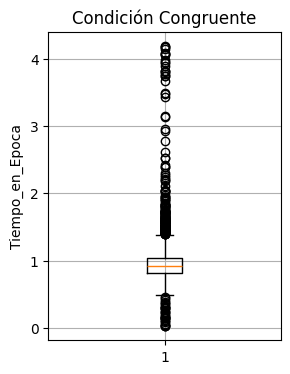

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 4))

plt.boxplot(tiempos_por_marca['S 31'])

plt.title("Condición Congruente")
plt.ylabel("Tiempo_en_Epoca")
plt.grid(True)
plt.show()


In [92]:
tiempos_por_marca['S 43']

[4.06640625, 3.8134765625]

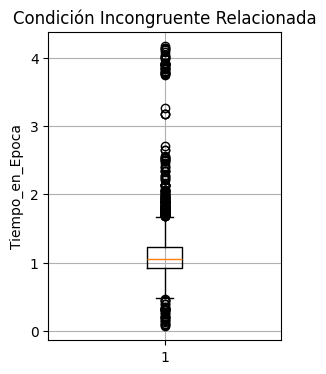

In [111]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 4))

plt.boxplot(tiempos_por_marca['S 41'])
plt.title("Condición Incongruente Relacionada")
plt.ylabel("Tiempo_en_Epoca")
plt.grid(True)

plt.show()


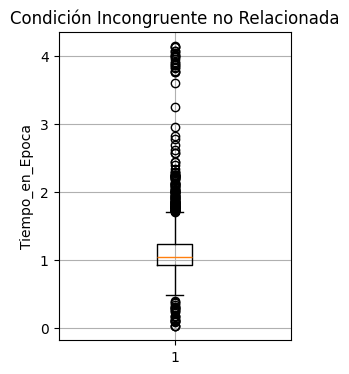

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 4))

plt.boxplot(tiempos_por_marca['S 42'])
plt.title("Condición Incongruente no Relacionada")
plt.ylabel("Tiempo_en_Epoca")
plt.grid(True)

plt.show()


In [14]:
tiempos_por_marca['S 31']

[0.8662109375,
 0.744140625,
 0.375,
 0.1806640625,
 0.3515625,
 0.8857421875,
 0.7509765625,
 0.791015625,
 0.759765625,
 1.08203125,
 0.9892578125,
 0.83984375,
 0.7841796875,
 1.0537109375,
 0.849609375,
 2.052734375,
 1.00390625,
 1.146484375,
 0.826171875,
 0.8232421875,
 0.794921875,
 0.96484375,
 0.9326171875,
 1.1748046875,
 0.9892578125,
 1.0,
 1.173828125,
 0.8798828125,
 1.05078125,
 0.8828125,
 0.8115234375,
 0.8828125,
 0.5478515625,
 1.1162109375,
 1.1484375,
 1.18359375,
 1.0029296875,
 1.279296875,
 0.951171875,
 1.1640625,
 0.888671875,
 0.896484375,
 1.041015625,
 1.33203125,
 0.9951171875,
 1.283203125,
 1.1630859375,
 1.2431640625,
 0.84375,
 0.8828125,
 1.203125,
 1.4111328125,
 0.66015625,
 0.9541015625,
 0.87890625,
 0.8505859375,
 0.958984375,
 0.876953125,
 0.87890625,
 0.779296875,
 0.8359375,
 1.638671875,
 0.814453125,
 0.8662109375,
 1.076171875,
 0.6630859375,
 1.0546875,
 0.82421875,
 0.845703125,
 0.90625,
 0.8759765625,
 0.787109375,
 1.12890625,
 1.140

In [15]:
Marcas_Eventos_Relativo.keys()

dict_keys(['con', 'rel', 'unrel'])

In [16]:
Marcas_Eventos_Relativo['con'].keys()

dict_keys(['Sujeto_1', 'Sujeto_2', 'Sujeto_3', 'Sujeto_4', 'Sujeto_5', 'Sujeto_6', 'Sujeto_7', 'Sujeto_8', 'Sujeto_9', 'Sujeto_10', 'Sujeto_11', 'Sujeto_12', 'Sujeto_13', 'Sujeto_14', 'Sujeto_15', 'Sujeto_16', 'Sujeto_17', 'Sujeto_18', 'Sujeto_19', 'Sujeto_20', 'Sujeto_21', 'Sujeto_22', 'Sujeto_23', 'Sujeto_24', 'Sujeto_25', 'Sujeto_26', 'Sujeto_27', 'Sujeto_28', 'Sujeto_29', 'Sujeto_30', 'Sujeto_31', 'Sujeto_32', 'Sujeto_33', 'Sujeto_34', 'Sujeto_35', 'Sujeto_36', 'Sujeto_37', 'Sujeto_38', 'Sujeto_39', 'Sujeto_40'])

In [17]:
Marcas_Eventos_Relativo['con']['Sujeto_1'].keys()

Index(['Type', 'Latency', 'Tiempo_Relativo', 'Tiempo_en_Epoca',
       'Sample_en_Epoca'],
      dtype='object')

In [22]:
import pandas as pd
import copy

# Nombres nuevos de columnas
nuevos_nombres = {
    'Type': 'Tipo_Evento',
    'Latency': 'Tiempo_total_Sample',
    'Tiempo_Relativo': 'Tiempo_total_Segundos',
    'Tiempo_en_Epoca': 'Tiempo_Relativo_Epoca_Segundos',
    'Sample_en_Epoca': 'Tiempo_Relativo_Epoca_sample'
}

# Copiar profundamente el diccionario original
Marcas_Eventos_Relativo_Renombrado = copy.deepcopy(Marcas_Eventos_Relativo)

# Aplicar renombramiento en la copia
for condicion in ['con', 'rel', 'unrel']:
    for sujeto, df in Marcas_Eventos_Relativo_Renombrado[condicion].items():
        if isinstance(df, pd.DataFrame):
            Marcas_Eventos_Relativo_Renombrado[condicion][sujeto] = df.rename(columns=nuevos_nombres)
        else:
            print(f"Advertencia: {condicion} - {sujeto} no tiene un DataFrame válido.")


Advertencia: con - Sujeto_11 no tiene un DataFrame válido.
Advertencia: con - Sujeto_12 no tiene un DataFrame válido.
Advertencia: con - Sujeto_20 no tiene un DataFrame válido.
Advertencia: con - Sujeto_30 no tiene un DataFrame válido.
Advertencia: con - Sujeto_39 no tiene un DataFrame válido.
Advertencia: rel - Sujeto_11 no tiene un DataFrame válido.
Advertencia: rel - Sujeto_12 no tiene un DataFrame válido.
Advertencia: rel - Sujeto_20 no tiene un DataFrame válido.
Advertencia: rel - Sujeto_30 no tiene un DataFrame válido.
Advertencia: rel - Sujeto_39 no tiene un DataFrame válido.
Advertencia: unrel - Sujeto_11 no tiene un DataFrame válido.
Advertencia: unrel - Sujeto_12 no tiene un DataFrame válido.
Advertencia: unrel - Sujeto_20 no tiene un DataFrame válido.
Advertencia: unrel - Sujeto_30 no tiene un DataFrame válido.
Advertencia: unrel - Sujeto_39 no tiene un DataFrame válido.


In [21]:
Marcas_Eventos_Relativo['con']['Sujeto_1']

,Tipo_Evento,Tiempo_total_Sample,Tiempo_total_Segundos,Tiempo_Relativo_Epoca_Segundos,Tiempo_Relativo_Epoca_sample
0,S 11,206,4.904534,0.201172,206
1,S 31,887,21.118066,0.866211,887
2,S 11,4507,107.304534,0.201172,206
3,S 11,8808,209.704534,0.201172,206
4,S 11,13109,312.104534,0.201172,206
...,...,...,...,...,...
174,S 31,379511,9035.556010,0.999023,1023
175,S 11,382995,9118.504534,0.201172,206
176,S 31,383802,9137.717926,0.989258,1013
177,S 11,387296,9220.904534,0.201172,206


In [23]:
Marcas_Eventos_Relativo_Renombrado

{'con': {'Sujeto_1':     Tipo_Evento  Tiempo_total_Sample  Tiempo_total_Segundos  \
  0          S 11                  206               4.904534   
  1          S 31                  887              21.118066   
  2          S 11                 4507             107.304534   
  3          S 11                 8808             209.704534   
  4          S 11                13109             312.104534   
  ..          ...                  ...                    ...   
  174        S 31               379511            9035.556010   
  175        S 11               382995            9118.504534   
  176        S 31               383802            9137.717926   
  177        S 11               387296            9220.904534   
  178        S 31               388044            9238.713229   
  
       Tiempo_Relativo_Epoca_Segundos  Tiempo_Relativo_Epoca_sample  
  0                          0.201172                           206  
  1                          0.866211                     

In [24]:
import os

# Crear carpeta si no existe
carpeta_salida = "marcas_sujetos"
os.makedirs(carpeta_salida, exist_ok=True)

# Guardar cada DataFrame
for condicion in ['con', 'rel', 'unrel']:
    for sujeto, df in Marcas_Eventos_Relativo_Renombrado[condicion].items():
        if isinstance(df, pd.DataFrame):
            nombre_archivo = f"{sujeto}_{condicion}.csv"
            ruta_archivo = os.path.join(carpeta_salida, nombre_archivo)
            df.to_csv(ruta_archivo, index=False)
        else:
            print(f"Advertencia: No se guardó {sujeto} en condición {condicion} (no es un DataFrame)")


Advertencia: No se guardó Sujeto_11 en condición con (no es un DataFrame)
Advertencia: No se guardó Sujeto_12 en condición con (no es un DataFrame)
Advertencia: No se guardó Sujeto_20 en condición con (no es un DataFrame)
Advertencia: No se guardó Sujeto_30 en condición con (no es un DataFrame)
Advertencia: No se guardó Sujeto_39 en condición con (no es un DataFrame)
Advertencia: No se guardó Sujeto_11 en condición rel (no es un DataFrame)
Advertencia: No se guardó Sujeto_12 en condición rel (no es un DataFrame)
Advertencia: No se guardó Sujeto_20 en condición rel (no es un DataFrame)
Advertencia: No se guardó Sujeto_30 en condición rel (no es un DataFrame)
Advertencia: No se guardó Sujeto_39 en condición rel (no es un DataFrame)
Advertencia: No se guardó Sujeto_11 en condición unrel (no es un DataFrame)
Advertencia: No se guardó Sujeto_12 en condición unrel (no es un DataFrame)
Advertencia: No se guardó Sujeto_20 en condición unrel (no es un DataFrame)
Advertencia: No se guardó Sujeto

In [61]:
# Marcas de interés por condición
marcas_interes = {
    'con': 'S 31',
    'rel': 'S 41',
    'unrel': 'S 42'
}

# Inicializar listas
tiempos_con = []
tiempos_rel = []
tiempos_unrel = []

# Diccionario para mapear condición → lista correspondiente
tiempos_dict = {
    'con': tiempos_con,
    'rel': tiempos_rel,
    'unrel': tiempos_unrel
}

# Recorrer y extraer los valores de 'Tiempo_Relativo_Epoca_Segundos'
for condicion, marca in marcas_interes.items():
    for sujeto, df in Marcas_Eventos_Relativo_Renombrado[condicion].items():
        if isinstance(df, pd.DataFrame):
            valores = df[df['Tipo_Evento'] == marca]['Tiempo_Relativo_Epoca_Segundos'].tolist()
            tiempos_dict[condicion].extend(valores)


In [32]:
tiempos_dict['rel']

[0.7216796875,
 0.9150390625,
 1.2734375,
 0.3017578125,
 0.7490234375,
 3.861328125,
 1.0078125,
 1.2568359375,
 1.001953125,
 0.9521484375,
 1.068359375,
 0.9853515625,
 1.009765625,
 1.8310546875,
 0.310546875,
 1.1923828125,
 1.2314453125,
 0.88671875,
 0.9677734375,
 0.865234375,
 0.888671875,
 1.474609375,
 1.09375,
 1.1162109375,
 1.1689453125,
 0.9794921875,
 1.0771484375,
 1.2578125,
 0.99609375,
 1.1201171875,
 1.0087890625,
 1.474609375,
 0.986328125,
 1.25,
 1.5185546875,
 2.03515625,
 1.083984375,
 1.0419921875,
 1.0595703125,
 1.28125,
 1.0126953125,
 1.0126953125,
 1.337890625,
 1.0771484375,
 1.1865234375,
 1.4072265625,
 1.8232421875,
 2.51171875,
 1.3193359375,
 1.3193359375,
 0.9462890625,
 1.2822265625,
 0.990234375,
 1.310546875,
 1.0673828125,
 1.15625,
 1.009765625,
 0.9599609375,
 1.2548828125,
 1.0361328125,
 0.998046875,
 1.00390625,
 0.970703125,
 0.9443359375,
 1.7822265625,
 0.986328125,
 1.1015625,
 1.2548828125,
 1.3486328125,
 1.037109375,
 1.2265625,
 1

In [38]:
import os
import pandas as pd

# Crear carpeta si no existe
output_folder = "tiempos_condiciones"
os.makedirs(output_folder, exist_ok=True)

# Diccionario con las listas de tiempos por condición
tiempos_por_condicion = {
    'con': tiempos_con,
    'rel': tiempos_rel,
    'unrel': tiempos_unrel
}

# Guardar cada condición en un CSV
for condicion, tiempos in tiempos_por_condicion.items():
    df = pd.DataFrame({ 'Tiempo_Relativo_Epoca_Segundos': tiempos })
    file_path = os.path.join(output_folder, f"tiempos_{condicion}.csv")
    df.to_csv(file_path, index=False)

print(f"Archivos guardados en carpeta: {output_folder}")


Archivos guardados en carpeta: tiempos_condiciones


C:\Users\Usuario\AppData\Local\Temp\ipykernel_7716\2761238401.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='Condición', y='Tiempo', palette='Set2')


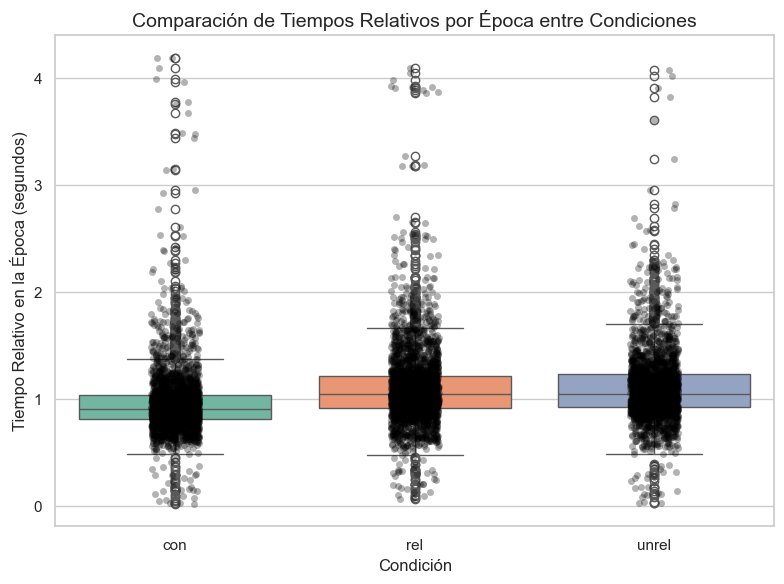

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un DataFrame largo (formato tidy)
df_box = pd.DataFrame({
    'Tiempo': tiempos_con + tiempos_rel + tiempos_unrel,
    'Condición': ['con'] * len(tiempos_con) + ['rel'] * len(tiempos_rel) + ['unrel'] * len(tiempos_unrel)
})

# Estilo de seaborn
sns.set(style="whitegrid", palette="pastel")

# Crear boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_box, x='Condición', y='Tiempo', palette='Set2')
sns.stripplot(data=df_box, x='Condición', y='Tiempo', color='black', alpha=0.3, jitter=True)

plt.title('Comparación de Tiempos Relativos por Época entre Condiciones', fontsize=14)
plt.ylabel('Tiempo Relativo en la Época (segundos)')
plt.xlabel('Condición')
plt.tight_layout()
plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_7716\937597144.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, y='Condición', x='Tiempo', palette='Set2')


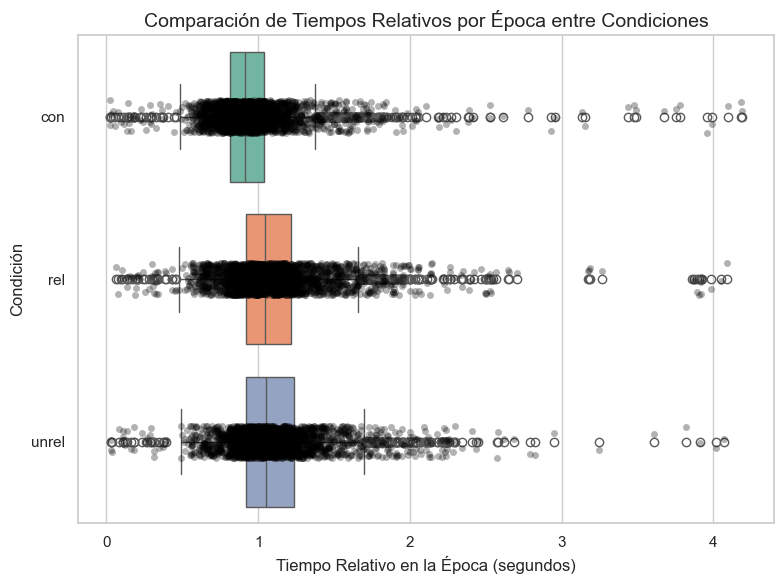

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un DataFrame largo (formato tidy)
df_box = pd.DataFrame({
    'Tiempo': tiempos_con + tiempos_rel + tiempos_unrel,
    'Condición': ['con'] * len(tiempos_con) + ['rel'] * len(tiempos_rel) + ['unrel'] * len(tiempos_unrel)
})

# Estilo de seaborn
sns.set(style="whitegrid", palette="pastel")

# Crear boxplot horizontal
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_box, y='Condición', x='Tiempo', palette='Set2')
sns.stripplot(data=df_box, y='Condición', x='Tiempo', color='black', alpha=0.3, jitter=True, orient='h')

plt.title('Comparación de Tiempos Relativos por Época entre Condiciones', fontsize=14)
plt.xlabel('Tiempo Relativo en la Época (segundos)')
plt.ylabel('Condición')
plt.tight_layout()
plt.show()


In [35]:
import numpy as np
from scipy.stats import permutation_test

# Definición de la función estadística
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

# Convertir listas a arrays (por si acaso)
tiempos_con = np.array(tiempos_con)
tiempos_rel = np.array(tiempos_rel)
tiempos_unrel = np.array(tiempos_unrel)

# Test 1: con vs rel
res_con_rel = permutation_test((tiempos_con, tiempos_rel), statistic, 
                               vectorized=True, n_resamples=5000, alternative='less')

# Test 2: con vs unrel
res_con_unrel = permutation_test((tiempos_con, tiempos_unrel), statistic, 
                                 vectorized=True, n_resamples=5000, alternative='less')

# Test 3: rel vs unrel
res_rel_unrel = permutation_test((tiempos_rel, tiempos_unrel), statistic, 
                                 vectorized=True, n_resamples=5000, alternative='less')

# Mostrar resultados
print("Test con vs rel")
print(f"Statistic: {res_con_rel.statistic:.4f}, p-value: {res_con_rel.pvalue:.4f}\n")

print("Test con vs unrel")
print(f"Statistic: {res_con_unrel.statistic:.4f}, p-value: {res_con_unrel.pvalue:.4f}\n")

print("Test rel vs unrel")
print(f"Statistic: {res_rel_unrel.statistic:.4f}, p-value: {res_rel_unrel.pvalue:.4f}")


Test con vs rel
Statistic: -0.1437, p-value: 0.0002

Test con vs unrel
Statistic: -0.1454, p-value: 0.0002

Test rel vs unrel
Statistic: -0.0017, p-value: 0.4335


In [59]:
import numpy as np
from scipy.stats import f_oneway

# Convertir listas a arrays por si acaso
tiempos_con = np.array(tiempos_con)
tiempos_rel = np.array(tiempos_rel)
tiempos_unrel = np.array(tiempos_unrel)

# ANOVA de un factor
f_stat, p_value = f_oneway(tiempos_con, tiempos_rel, tiempos_unrel)

# Mostrar resultados
print("ANOVA de un factor (una vía)")
print(f"F = {f_stat:.4f}")
print(f"p-value = {p_value:.4f}")


ANOVA de un factor (una vía)
F = 158.2988
p-value = 0.0000


In [36]:
from statsmodels.stats.multitest import multipletests

# P-values obtenidos en los tests
p_values = np.array([
    res_con_rel.pvalue,
    res_con_unrel.pvalue,
    res_rel_unrel.pvalue
])

# Corrección FDR (Benjamini-Hochberg)
rej, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

print("P-values originales:", p_values)
print("P-values corregidos (FDR):", pvals_corrected)
print("Rechazar H0 con FDR?:", rej)


P-values originales: [1.99960008e-04 1.99960008e-04 4.33513297e-01]
P-values corregidos (FDR): [2.99940012e-04 2.99940012e-04 4.33513297e-01]
Rechazar H0 con FDR?: [ True  True False]


In [37]:
pvals_corrected

array([2.99940012e-04, 2.99940012e-04, 4.33513297e-01])

Advertencia: El dataframe para con - Sujeto_11 es None, se omite.
Advertencia: El dataframe para con - Sujeto_12 es None, se omite.
Advertencia: El dataframe para con - Sujeto_20 es None, se omite.
Advertencia: El dataframe para con - Sujeto_30 es None, se omite.
Advertencia: El dataframe para con - Sujeto_39 es None, se omite.


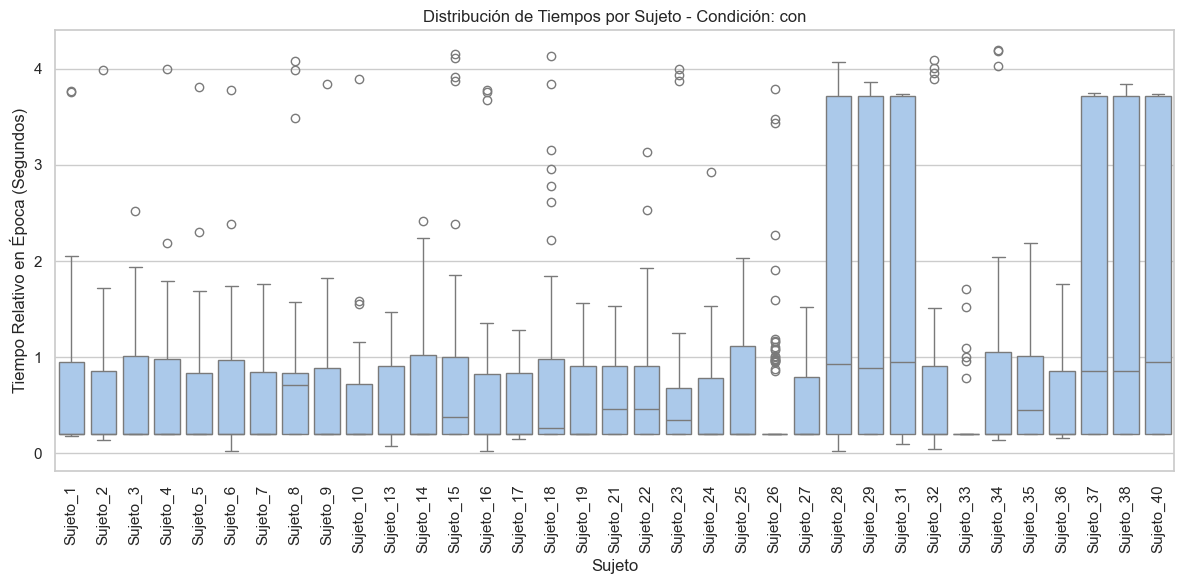

Advertencia: El dataframe para rel - Sujeto_11 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_12 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_20 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_30 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_39 es None, se omite.


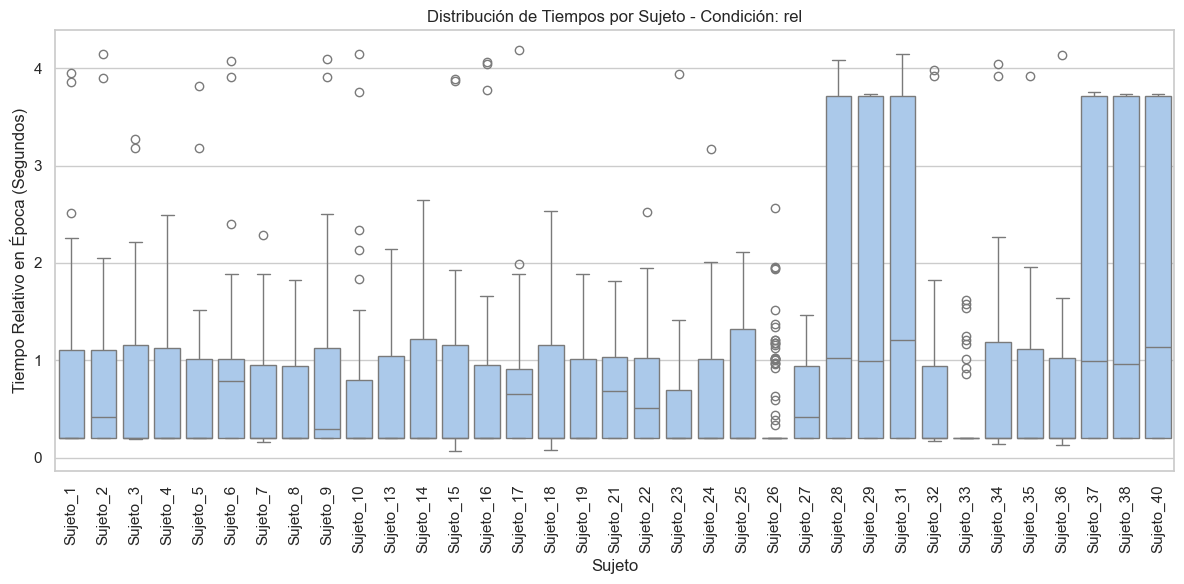

Advertencia: El dataframe para unrel - Sujeto_11 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_12 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_20 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_30 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_39 es None, se omite.


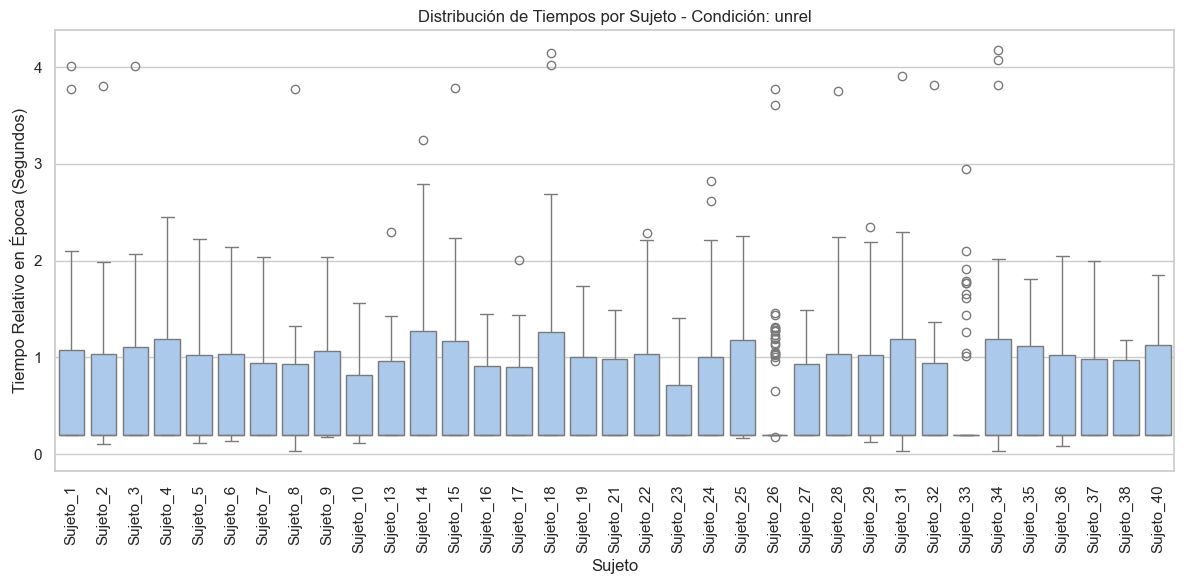

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

condiciones = ['con', 'rel', 'unrel']

for condicion in condiciones:
    lista_df = []
    for sujeto, df in Marcas_Eventos_Relativo_Renombrado[condicion].items():
        if df is None:
            print(f"Advertencia: El dataframe para {condicion} - {sujeto} es None, se omite.")
            continue
        df_temp = df[['Tiempo_Relativo_Epoca_Segundos']].copy()
        df_temp['Sujeto'] = sujeto
        lista_df.append(df_temp)

    if not lista_df:
        print(f"No hay datos para la condición {condicion}, se omite el gráfico.")
        continue

    df_condicion = pd.concat(lista_df, ignore_index=True)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Sujeto', y='Tiempo_Relativo_Epoca_Segundos', data=df_condicion)
    plt.title(f"Distribución de Tiempos por Sujeto - Condición: {condicion}")
    plt.xticks(rotation=90)
    plt.ylabel("Tiempo Relativo en Época (Segundos)")
    plt.xlabel("Sujeto")
    plt.tight_layout()
    plt.show()


Advertencia: El dataframe para con - Sujeto_11 es None, se omite.
Advertencia: El dataframe para con - Sujeto_12 es None, se omite.
Advertencia: El dataframe para con - Sujeto_20 es None, se omite.
Advertencia: El dataframe para con - Sujeto_30 es None, se omite.
Advertencia: El dataframe para con - Sujeto_39 es None, se omite.


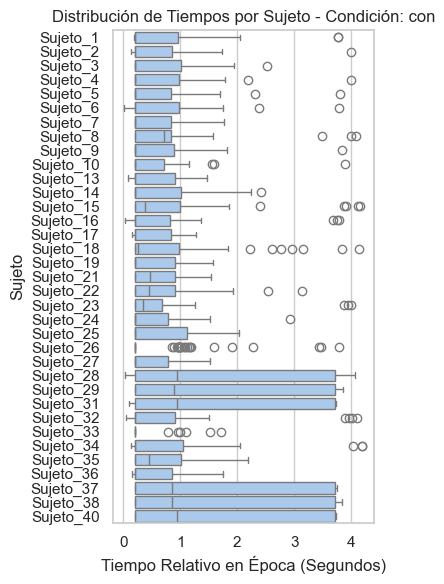

Advertencia: El dataframe para rel - Sujeto_11 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_12 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_20 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_30 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_39 es None, se omite.


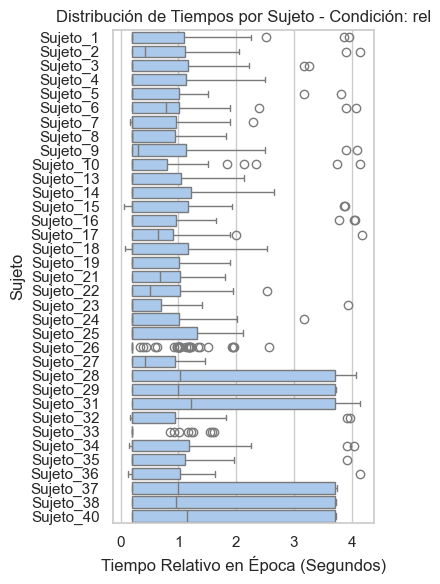

Advertencia: El dataframe para unrel - Sujeto_11 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_12 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_20 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_30 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_39 es None, se omite.


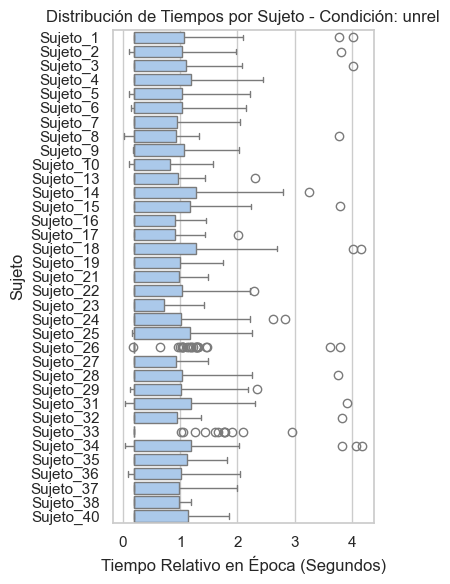

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

condiciones = ['con', 'rel', 'unrel']

for condicion in condiciones:
    lista_df = []
    for sujeto, df in Marcas_Eventos_Relativo_Renombrado[condicion].items():
        if df is None:
            print(f"Advertencia: El dataframe para {condicion} - {sujeto} es None, se omite.")
            continue
        df_temp = df[['Tiempo_Relativo_Epoca_Segundos']].copy()
        df_temp['Sujeto'] = sujeto
        lista_df.append(df_temp)

    if not lista_df:
        print(f"No hay datos para la condición {condicion}, se omite el gráfico.")
        continue

    df_condicion = pd.concat(lista_df, ignore_index=True)

    plt.figure(figsize=(4, 6))  # Alto mayor que ancho para horizontal
    sns.boxplot(y='Sujeto', x='Tiempo_Relativo_Epoca_Segundos', data=df_condicion, orient='h')
    plt.title(f"Distribución de Tiempos por Sujeto - Condición: {condicion}")
    plt.ylabel("Sujeto")
    plt.xlabel("Tiempo Relativo en Época (Segundos)")
    plt.tight_layout()
    plt.show()


Advertencia: El dataframe para con - Sujeto_11 es None, se omite.
Advertencia: El dataframe para con - Sujeto_12 es None, se omite.
Advertencia: El dataframe para con - Sujeto_20 es None, se omite.
Advertencia: El dataframe para con - Sujeto_30 es None, se omite.
Advertencia: El dataframe para con - Sujeto_39 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_11 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_12 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_20 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_30 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_39 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_11 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_12 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_20 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_30 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_39 es None, se omite.


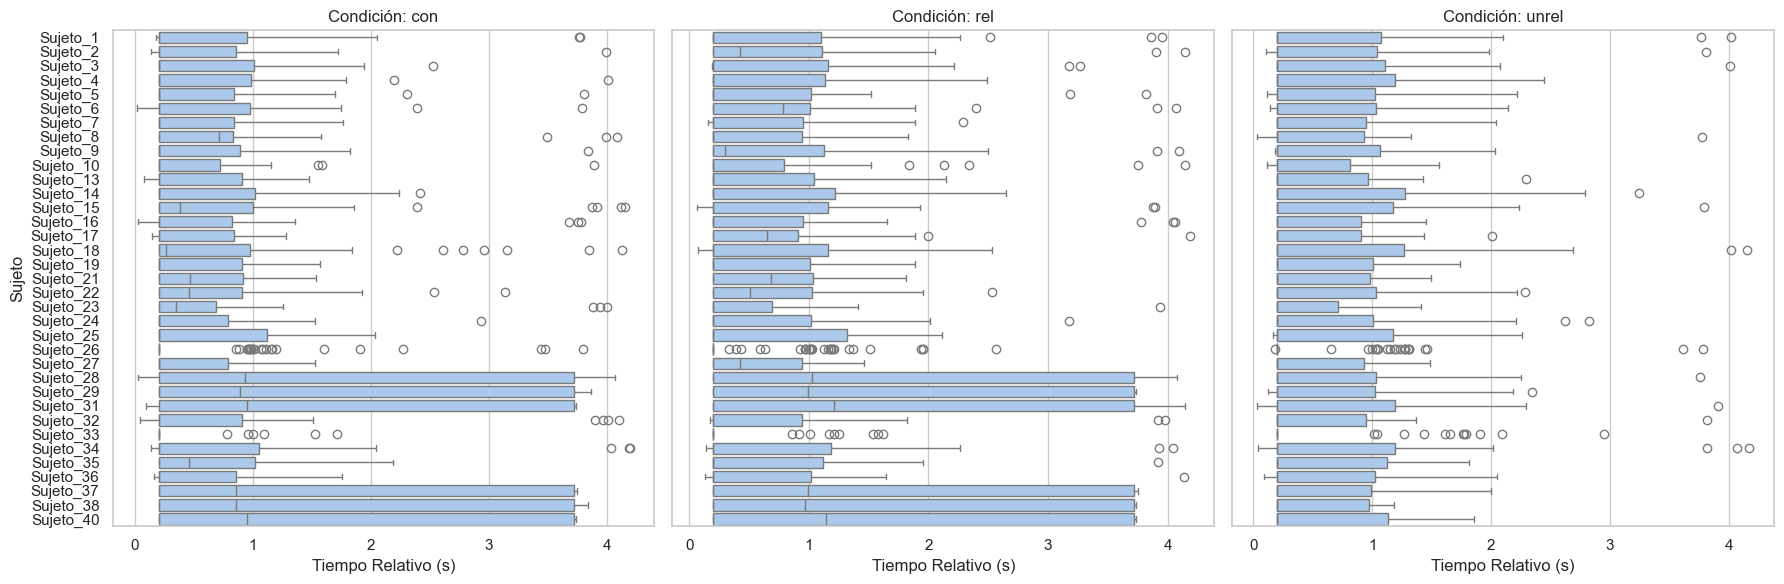

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # por si no lo tienes importado

condiciones = ['con', 'rel', 'unrel']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 3 columnas, alto de 6, ancho de 18
# sharey=True para que los sujetos estén alineados en los tres gráficos

for i, condicion in enumerate(condiciones):
    lista_df = []
    for sujeto, df in Marcas_Eventos_Relativo_Renombrado[condicion].items():
        if df is None:
            print(f"Advertencia: El dataframe para {condicion} - {sujeto} es None, se omite.")
            continue
        df_temp = df[['Tiempo_Relativo_Epoca_Segundos']].copy()
        df_temp['Sujeto'] = sujeto
        lista_df.append(df_temp)

    if not lista_df:
        print(f"No hay datos para la condición {condicion}, se omite el gráfico.")
        axes[i].set_visible(False)
        continue

    df_condicion = pd.concat(lista_df, ignore_index=True)

    sns.boxplot(
        y='Sujeto',
        x='Tiempo_Relativo_Epoca_Segundos',
        data=df_condicion,
        orient='h',
        ax=axes[i]
    )
    axes[i].set_title(f"Condición: {condicion}")
    axes[i].set_ylabel("Sujeto" if i == 0 else "")  # solo el primer subplot tiene etiqueta y
    axes[i].set_xlabel("Tiempo Relativo (s)")

plt.tight_layout()
plt.show()


In [57]:
Marcas_Eventos_Relativo_Renombrado['con']['Sujeto_1']['Tipo_Evento']

0      S 11
1      S 31
2      S 11
3      S 11
4      S 11
       ... 
174    S 31
175    S 11
176    S 31
177    S 11
178    S 31
Name: Tipo_Evento, Length: 179, dtype: object

Advertencia: El dataframe para con - Sujeto_11 es None, se omite.
Advertencia: El dataframe para con - Sujeto_12 es None, se omite.
Advertencia: El dataframe para con - Sujeto_20 es None, se omite.
Advertencia: El dataframe para con - Sujeto_30 es None, se omite.
Advertencia: El dataframe para con - Sujeto_39 es None, se omite.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_7716\262543797.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Advertencia: El dataframe para rel - Sujeto_11 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_12 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_20 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_30 es None, se omite.
Advertencia: El dataframe para rel - Sujeto_39 es None, se omite.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_7716\262543797.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Advertencia: El dataframe para unrel - Sujeto_11 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_12 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_20 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_30 es None, se omite.
Advertencia: El dataframe para unrel - Sujeto_39 es None, se omite.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_7716\262543797.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


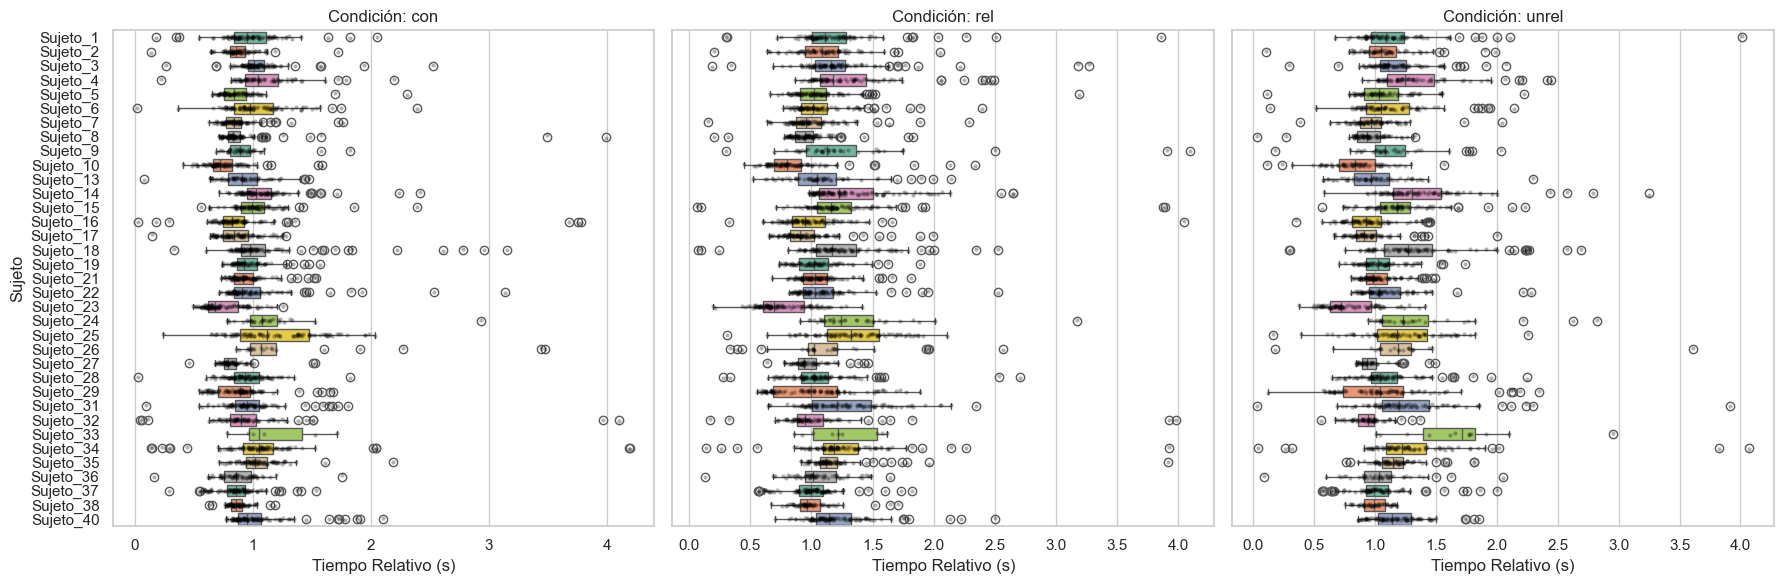

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Estilo de seaborn
sns.set(style="whitegrid", palette="pastel")

# Diccionario que relaciona condición con el tipo de evento de respuesta
eventos_respuesta = {
    'con': 'S 31',
    'rel': 'S 41',
    'unrel': 'S 42'
}

condiciones = ['con', 'rel', 'unrel']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, condicion in enumerate(condiciones):
    lista_df = []
    tipo_respuesta = eventos_respuesta[condicion]

    for sujeto, df in Marcas_Eventos_Relativo_Renombrado[condicion].items():
        if df is None:
            print(f"Advertencia: El dataframe para {condicion} - {sujeto} es None, se omite.")
            continue

        # Filtrar SOLO los eventos de respuesta
        df_filtrado = df[df['Tipo_Evento'] == tipo_respuesta].copy()
        if df_filtrado.empty:
            continue

        df_filtrado = df_filtrado[['Tiempo_Relativo_Epoca_Segundos']].copy()
        df_filtrado['Sujeto'] = sujeto
        lista_df.append(df_filtrado)

    if not lista_df:
        print(f"No hay marcas de respuesta para la condición {condicion}, se omite el gráfico.")
        axes[i].set_visible(False)
        continue

    df_condicion = pd.concat(lista_df, ignore_index=True)

    # Boxplot horizontal
    sns.boxplot(
        y='Sujeto',
        x='Tiempo_Relativo_Epoca_Segundos',
        data=df_condicion,
        orient='h',
        ax=axes[i],
        palette='Set2'
    )

    # Puntos encima (stripplot)
    sns.stripplot(
        y='Sujeto',
        x='Tiempo_Relativo_Epoca_Segundos',
        data=df_condicion,
        orient='h',
        ax=axes[i],
        color='black',
        alpha=0.3,
        jitter=True,
        size=3
    )

    axes[i].set_title(f"Condición: {condicion}")
    axes[i].set_ylabel("Sujeto" if i == 0 else "")
    axes[i].set_xlabel("Tiempo Relativo (s)")

plt.tight_layout()
plt.show()
